In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import sklearn 
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os
import sys

current_folder_path = os.path.abspath('')

## Loading the labeled dataset
The numpy array has the following shapes :
- 6556 rows, reprensenting 6556 event occurences
- 1445 columns representing :  
-- 1 column of step value (initialized for every serie id (ie test subject))  
-- 721 columns of **anglez** samples, centered 30 minutes before and after an event  
-- 721 columns of **enmo** samples, centered 30 minutes before and after an event  
-- 1 column of timestamp, ie the moment of the sample   
-- 1 column of **event** which is the **target** of the dataset. (0: *onset*, 1: *wakeup*)  

In [2]:
offset = 12
data = np.load(f"{current_folder_path}/training_data/data_{offset}.npy")
print(data.shape)

#[step, :, :, timestamp, event]
step = data[:,0]
X = data[:, 1:-2]
Y = data[:, -1]


(6563, 53)


## Data splitting
The parquet dataset, loaded as an edited npy array, is divided into training and testing datasets

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

train_features = torch.from_numpy(X_train).float()
train_labels = torch.from_numpy(Y_train).float().unsqueeze(1)
test_features = torch.from_numpy(X_test).float()
test_labels = torch.from_numpy(Y_test).float().unsqueeze(1)

train_features = F.normalize(train_features)
test_features = F.normalize(test_features)

print(train_features.size(), train_labels.size(), test_features.size(), test_labels.size())

torch.Size([4922, 50]) torch.Size([4922, 1]) torch.Size([1641, 50]) torch.Size([1641, 1])


## NN architecture

In [4]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.input_size = input_size
        self.hidden_size= hidden_size
        self.output_size = output_size
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

        self.input_layer = nn.Linear(input_size, hidden_size)
        
        self.layer1 = nn.Linear(hidden_size, hidden_size//2)
        self.layer2 = nn.Linear(hidden_size//2, hidden_size//4)
        
        self.batchnorm1 = nn.BatchNorm1d(hidden_size//2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size//4)

        self.output_layer = nn.Linear(hidden_size//4, output_size)
        self.sigmoid = nn.Sigmoid()  
        self.dropout = nn.Dropout1d(p=0.1)
            
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        
        x = self.layer2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        x = self.output_layer(x)  
        #x = self.relu(x)    
        x = self.sigmoid(x)
        return x        



## Model training

50


100%|██████████| 1000/1000 [00:12<00:00, 79.28it/s]

Epoch 1000, Loss: 436.1320701241493, Final Loss: 0.36331814527511597


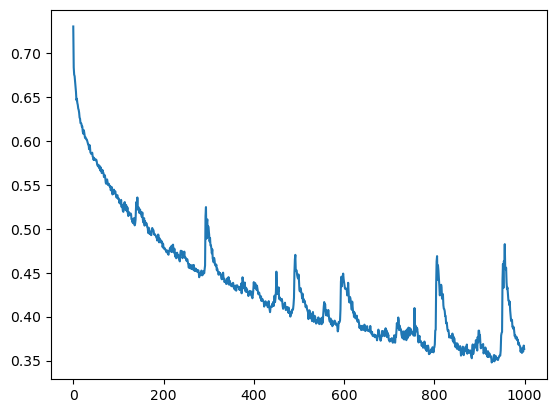

In [17]:
m, n = train_features.shape
input_size = n
print(input_size)
hidden_size = 64
output_size = 1

model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimize = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

model.train() 
running_loss = 0.0

losses_list = []
num_epochs = int(input("Number of epochs : "))    
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    outputs = model(train_features)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    losses_list.append(loss.item())

print(f"Epoch {epoch+1}, Loss: {running_loss}, Final Loss: {losses_list[-1]}")
#print(np.round(losses_list[::2], 6))

import matplotlib.pyplot as plt
plt.plot(losses_list)


## Model testing

#### Training dataset

In [18]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    outputs = model(test_features) 
    #print(test_features[0:10])
    print(outputs[0:10].T)
    #predicted = torch.round(outputs.data)
    #_, predicted = torch.max(outputs.data, 1)
    predicted = torch.round(outputs.data)
    # predicted = np.round(outputs.numpy())
    total += test_labels.size(0)
    # correct += (predicted.numpy() == test_labels.numpy().T).sum().item()
    correct += (predicted == test_labels).sum().item()        
    
    print(predicted[0:10].T)
    print(test_labels[0:10].T)
    #print(predicted.numpy()[0:10].T, test_labels.numpy().T[0, 0:10])
    #correct += (predicted == test_labels.numpy().T[0]).sum().item()
    # print(total, correct)

    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")

tensor([[9.8349e-01, 4.9188e-01, 7.5392e-01, 6.9628e-04, 6.9074e-01, 6.9814e-01,
         6.9963e-01, 8.8787e-01, 7.6033e-01, 9.7498e-01]])
tensor([[1., 0., 1., 0., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 0., 1., 1., 1., 1., 1., 1.]])
1641 1120
Accuracy on test set: 68.25%


## Model application
#### Submission dataset

In [20]:
offset = 12

data_sub = np.load(f"{current_folder_path}/submission_col.npy", allow_pickle=True)

#[series_id, step, anglez, enmo, timestamp]
series_id = data_sub[:, 0]
step = data_sub[:, 1]
anglez = np.array([data_sub[:, 2]])
enmo = np.array([data_sub[:, 3]])
timestamp = np.array([data_sub[:, 4]])

unique_series_id = np.array([np.unique(series_id)])
print(anglez[0, 0:150].shape, enmo.shape, timestamp.shape)


array1 = np.concatenate([anglez[0, 0:150], enmo[0, 0:150], timestamp[0, 0:150]]).reshape(1, 450)
array2 = np.concatenate([anglez[0, 150:300], enmo[0, 150:300], timestamp[0, 150:300]]).reshape(1, 450)
array3 = np.concatenate([anglez[0, 300:450], enmo[0, 300:450], timestamp[0, 300:450]]).reshape(1, 450)

# serie 1 : [anglez (150), enmo (150), timestamp (150)]
# serie 2 : [anglez (150), enmo (150), timestamp (150)]
# serie 3 : [anglez (150), enmo (150), timestamp (150)]
array = np.concatenate([array1, array2, array3], axis=0)
print(array.shape)

missed_values = []
outputs_arrays = np.zeros((3, 1))
for conv_step in tqdm(range(offset, 150-offset, 1)):
    # print(conv_step)
    # X_sub_offset is a [sample_of_anglez, sample_of_enmo] concatenation
    X_sub_offset = np.concatenate([array[:, conv_step-offset : conv_step+offset], 
                                   array[:, 150+conv_step-offset : 150+conv_step+offset]], axis=1)

    output_array = np.zeros((3, 1))
    for serie_idx in range(3):
        # X_sub_idx is the sample of only one of the 3 test subjects
        X_sub_idx = X_sub_offset[serie_idx, :]
        X_sub_idx = np.array([np.pad(X_sub_idx, 1, mode="edge").astype(np.float32)])

        #print(serie_idx, X_sub_idx.shape)

        submission_features = torch.from_numpy(X_sub_idx).float()
        submission_features = F.normalize(submission_features)

        if submission_features.size() == (50, 1):
            model.eval()
            with torch.no_grad():
                output_array[serie_idx, 0] = model(submission_features).numpy()

    outputs_arrays = np.concatenate([outputs_arrays, output_array], axis=1)
    m, n = output_array.shape

print(outputs_arrays.shape)

for serie_id in range(3):
    pred_onset = min(outputs_arrays[serie_id, :])
    step_onset = outputs_arrays[serie_id, :].to_list().index(step_onset)

    pred_wakeup = max(outputs_arrays[serie_id, :])
    step_wakeup = outputs_arrays[serie_id, :].to_list().index(step_onset)

    print(step_onset, round(pred_onset))
    print(step_onset, round(pred_onset))




# print(max(outputs_arrays[0, :]))
# print(X_sub_idx)
# print(submission_features)
# print(X_sub_idx.shape)


        






(150,) (1, 450) (1, 450)
(3, 450)


  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:00<00:00, 687.97it/s]

(3, 127)
3 1


## Garbage

(450, 302)
(450, 300)
(450, 302)


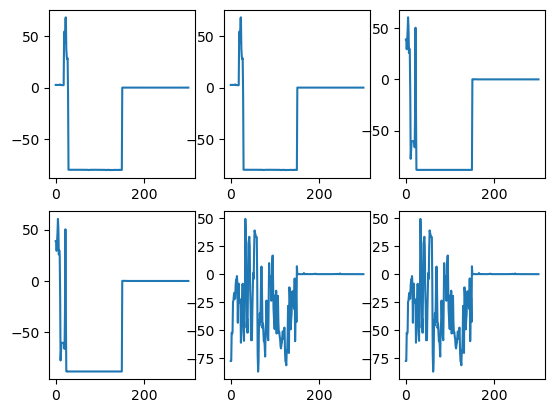

In [56]:
import matplotlib.pyplot as plt

data_sub = np.load(f"{current_folder_path}/submission.npy")
print(data_sub.shape)

#[step, :, :, timestamp]
step_sub = data_sub[:,0]
X_sub = data_sub[:, 1:-1]
print(X_sub.shape)

target_len = 302
padding_len = (target_len - X_sub.shape[1])//2
X_sub = np.pad(X_sub, padding_len, mode="edge")[padding_len:-padding_len, :]
print(X_sub.shape)

plt.subplots(2, 3)
for k in range(6):
    plt.subplot(2, 3, k+1)
    plt.plot(X_sub[k*75,:])


In [57]:
submission_features = torch.from_numpy(X_sub).float()

submission_features = F.normalize(submission_features)

print(submission_features.size())


torch.Size([450, 302])


#### Submission csv

(450, 1)
[0, '038441c925bb']
[[0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053]]
[0.052568890154361725] 0
[0.052568964660167694] 72
[2, '03d92c9f6f8a']
[[0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053]]
[0.052568890154361725] 0
[0.14496803283691406] 149
[4, '0402a003dae9']
[[0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053 0.053]]
[0.052568890154361725] 0
[0.14496803283691406] 148


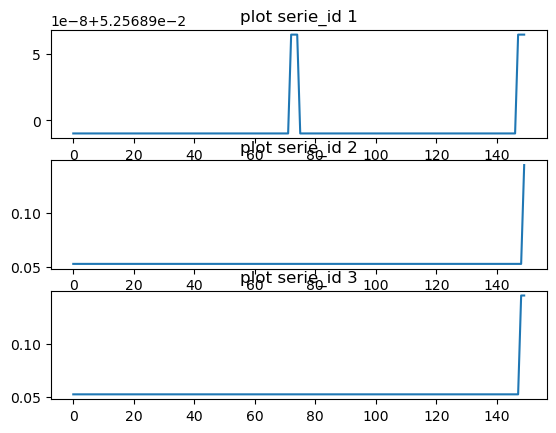

In [105]:
df_sample_submission = pd.read_csv(f"{current_folder_path}/sample_submission.csv")
columns=np.array([df_sample_submission.columns])
col = df_sample_submission.columns

arr_sample_submission = df_sample_submission.to_numpy()

model.eval()
with torch.no_grad():
    outputs = model(submission_features).numpy()

print(outputs.shape)
plt.subplots(3, 1)
len_test = outputs.shape[0]//150
for serie_id in range(len_test):
    answer_array_1 = []
    answer_array_2 = []

    # Row id 
    answer_array_1.append(serie_id*2)
    answer_array_2.append(serie_id*2+1)

    # series_id
    answer_array_1.append(df_sample_submission.iloc[serie_id*2, 1])
    answer_array_2.append(df_sample_submission.iloc[serie_id*2+1, 1])

    print(answer_array_1)

    current_serie = outputs.tolist()[serie_id:serie_id+150]
    print(np.round(current_serie[0:10], 3).T)
    score_onset, step_onset = min(current_serie), current_serie.index(min(current_serie))
    score_wakeup, step_wakeup = max(current_serie), current_serie.index(max(current_serie))

    print(score_onset, step_onset)
    print(score_wakeup, step_wakeup)

    plt.subplot(3, 1, serie_id+1)
    plt.plot(current_serie)
    plt.title(f"plot serie_id {serie_id+1}")

    # step
    answer_array_1.append(step_onset)
    answer_array_2.append(step_wakeup)

    # event
    answer_array_1.append(df_sample_submission.iloc[serie_id*2, 3])
    answer_array_2.append(df_sample_submission.iloc[serie_id*2+1, 3])

    # score
    answer_array_1.append(score_onset[0])
    answer_array_2.append(score_wakeup[0])

    # saving the submission
    arr_sample_submission[serie_id*2,:] = np.array(answer_array_1)
    arr_sample_submission[serie_id*2+1,:] = np.array(answer_array_2)

arr_sample_submission = np.concatenate([columns, arr_sample_submission], axis=0)
header = arr_sample_submission[0,:]
# Extract the data (excluding the header)
data = arr_sample_submission[1:,:]
# Create a Pandas DataFrame with the header
df = pd.DataFrame(data, columns=header)
df.to_csv(f"{current_folder_path}/submission.csv", index=False)
#np.savetxt(f"{current_folder_path}/anwer_sheet.txt", arr_sample_submission, delimiter=',')